# NYPD Allegations
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the outcome of an allegation (might need to feature engineer your output column).
    * Predict the complainant or officer ethnicity.
    * Predict the amount of time between the month received vs month closed (difference of the two columns).
    * Predict the rank of the officer.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this project we are trying to predict if a complainants allegation will be substaniated(officer was given punishment) or not. 

Given that our data set contains 66% unsubstantiated cases and 24% substantiated case our model would fit the fact that the values are mostly negative instead of our actual features to combat this we sampled the same amount of unsubstantiated(negative) data points as there are substantiated(positive) data points so that our data would contain equal proportions of each. Since we are working with the data set with equal amount of positive and negative values we use accuracy to measure how well our model fits the data. 

The idea for our project is influenced from our permutation test and exploratory data analysis that was done previously in project 3. In project 3 we assumed that females were more successful in their complaints than males but that wasn't the case in fact, it was quite the opposite. Now we can generalize what interesting findings we saw in project 3 and use it to predict success of a complaint given not only gender of complainants but police officer gender, police officer rank, or totally new features that we have engineered for this dataset.


### Baseline Model
We use two features in the baseline model: Complainant's age at time of incident and Complainant's gender. Age is quantitative so we just keep it as it is, and we one-hot encode gender, which is a nominal feature.

In our Baseline model we get:

Score train: .553

Score test: .510

The given test score for accuracy is slightly better than randomly guessing and in that sense it is not that great but the test and train scores are similar so we know that this model is not overfitting the data.


### Final Model
We added 8 more features to our final model: one numeric and the others are categorical. 

For numercial features, we added the Officer's age at time of incident because elder officers might be less likely to be substantiated, and we z scale both the officer's age and the complainant's age so that we don't skew data with larger or smaller values. 

For the categorical features, we added the complainant's ethnicity, officer's ethnicity, officer's gender, and month the complaint was received by CCRB. We think both gender and race of the officers and complainants are good predictor for our task because we already seen a dispositional allegations results in different gender from project3. We also added the month because the time that investigation started can also affect the result of allegations. For example, people might be less serious with cases received before a holiday.
We also did a feature engineer to create two binary features on whether the genders of complainant and the officer are the same, and whether the Officer's rank has changed. We assumed it is less likely that the officer would be substantiated if officer and complainant have the same gender and it is also less likely that the officer would be substantiated if his or her rank never changed(If you are promoted then it is likely you won't have complaints). Lastly, we included a numeric features representing the length of the case usually it means the case is complicated if the duration is long, and the complexity level of the case might also be a good predictor for our task.

For this project we used a Decision Tree Classifier because we are outputting a yes or no answer to the question: Will this person's complaint be substantiated? The parameters were chosen using a grid search K fold cross validation and we used the best parameters outputted which were max_depth=45,
min_sample_split = 2, and min_sample_leaf = 3. With this model we get:

Score train: 0.9268174787316319

Score test: 0.6218097447795824

### Fairness Evaluation
Given the current racial climate we wanted to investigate if our model is fair to white vs non white police officers more specifically we want to find out if police officers are correctly classified to be substantiated in both demographic since we use a lot of features involving race our model could have easily computed success or not given the ethnic demographic background of our Officers.

We decided to investigate this subset of our data and measure the fairness of our model using recall parity because we care more about mislabeling someone as substantiated when they shouldn't have been. This could lead to more dire consequences because that officer may be stripped of their career as opposed to letting a bad cop get away because they would eventually get caught again(assuming our justice system works as intended).

Now for the permutation test of sigif = .05. We have a null and an alternative hypothesis. 

- Null Hypothesis: My model is fair; the recall for White vs Non-White Officers are roughly the same

- Alternative Hypothesis: My model is unfair; the recall for White Officers is different than Non-White Officers.

We get a p value = .987 which fails to reject null at the sigfig of .05. With a p-value this large it seems that White vs Non-White officers are positively labeled correctly roughly the same and our model is fair to given the ethnicity of the Officer!

# Code

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


#### load the dataset

In [21]:
allegations = pd.read_csv('data/allegations.csv')
allegations = allegations.dropna()


#### cleaning

In [22]:
#clean the prediction
def clean_disposition(values):
    if "Substantiated" in values:
        return "Substantiated"
    elif "Unsubstantiated" in values:
        return "Unsubstantiated"
    elif "Exonerated" in values:
        return "Exonerated"
    
allegations["board_disposition"] =  allegations["board_disposition"].apply(clean_disposition)

In [23]:
# make a dataframe with equal amounts of both neg and pos occurences
allegations = allegations.replace({'Substantiated':1, 'Unsubstantiated':0, 'Exonerated':0})

num_pos = (allegations['board_disposition']==1).sum()
pos_allegations = allegations[allegations['board_disposition']==1]
neg_allegations = allegations[allegations['board_disposition']==0]
sampled_neg = neg_allegations.sample(n=num_pos,replace = False)
allegations = pd.concat([pos_allegations,sampled_neg])

In [24]:
allegations.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,1
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,1
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,1
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,1
5,10012,Paula,Smith,078 PCT,4021,37256,5,2017,10,2017,...,50,White,Male,31.0,Abuse of Authority,Refusal to process civilian complaint,78.0,C/V telephoned PCT,No arrest made or summons issued,1


### Baseline Model

build X and y dataset and split into train and test dataset

In [25]:
X = allegations.drop(columns = ['board_disposition'])
y = allegations['board_disposition']

feature engineer and build the model pipeline

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Numeric columns and associated transformers
num_feat = ['complainant_age_incident']
num_transformer = Pipeline(steps=[
    ('as_it_is', FunctionTransformer(lambda x:x))   # as it is
])

# Categorical columns and associated transformers
cat_feat = ['complainant_gender']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())     # output becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_feat),
        ('cat', cat_transformer, cat_feat)
    ])

pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', DecisionTreeClassifier())])

fit the train set to the model and get the performance

In [27]:
pl.fit(X_train, y_train)

print("score train: %s" % pl.score(X_train, y_train))
print("score test: %s" % pl.score(X_test, y_test))

score train: 0.5510440835266821
score test: 0.5084106728538283


In [28]:
preds = pl.predict(X_test)
print(metrics.confusion_matrix(y_test, preds)/ len(preds))


[[0.26334107 0.24158933]
 [0.25       0.24506961]]


### Final Model

build X and y dataset and split into train and test dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

feature engineer and build the model pipeline

In [92]:

# Numeric columns and associated transformers
num_feat = ['complainant_age_incident','mos_age_incident']
num_transformer = Pipeline(steps=[
    ('z_scale', StandardScaler())   # z_scale
])


# Categorical columns and associated transformers
cat_feat = ['complainant_gender', 'complainant_ethnicity', \
             'mos_ethnicity', 'mos_gender', 'month_received']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore"))  #OneHot encoding
])


#checks if two columsn are the same 
def equality(df):
    return (df[df.columns[0]]==df[df.columns[1]]).astype(int).to_frame()

same_transformer = Pipeline(steps=[
    ('equality_trasnformer',FunctionTransformer(equality))
])

#length of the case
date_feat = ['year_received','year_closed']
def date_diff(df):
    return (df[df.columns[1]]-df[df.columns[0]]).to_frame()

date_transformer =  Pipeline(steps=[
    ('datediff', FunctionTransformer(date_diff)),('std',StandardScaler())  
])


# preprocessing pipeline (put them together)
preproc = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_feat),
        ('cat', cat_transformer, cat_feat),
        ('same_gender',same_transformer,['mos_gender','complainant_gender']),
        ('rank_change',same_transformer,['rank_abbrev_now','rank_abbrev_incident']),
        ('datediff',date_transformer,date_feat)
    ])

pl = Pipeline(steps=[('preprocessor', preproc), ('Classifier', DecisionTreeClassifier(max_depth=45,min_samples_leaf= 1, min_samples_split=2))])

fit the train set to the model and get the performance

In [93]:
pl.fit(X_train, y_train)

print("score train: %s" % pl.score(X_train, y_train))
print("score test: %s" % pl.score(X_test, y_test))

score train: 0.9268174787316319
score test: 0.6218097447795824


In [58]:
preds = pl.predict(X_test)
print(metrics.confusion_matrix(y_test, preds)/ len(preds))


[[0.31235499 0.1861949 ]
 [0.17720418 0.32424594]]


#### Cross Validation 

we use GridSearchCV to get the best parameter max_depth equals to 35.

In [88]:
parameters = {
    'max_depth': [20,25,30,35,40,45,50], 
    'min_samples_split':[2,3,5,7,None],
    'min_samples_leaf':[1,2,3,5,7,None]
}

pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', GridSearchCV(DecisionTreeClassifier(),parameters,cv = 5))])
pl.fit(X_train, y_train)


print("score train: %s" % pl.score(X_train, y_train))
print("score test: %s" % pl.score(X_test, y_test))

score train: 0.9268174787316319
score test: 0.6238399071925754


In [89]:
pl.named_steps['regressor'].best_params_

{'max_depth': 45, 'min_samples_leaf': 1, 'min_samples_split': 2}

### Fairness Evaluation

Check if the model is fair for white vs non white complainants

In [36]:

preds = pl.predict(X_test)
results = X_test
results['prediction'] = preds
results['actual'] = y_test
results['is_white'] = (results['complainant_ethnicity']=='White').replace({True:'white',False:'non-white'})
metrics.confusion_matrix(y_test, preds) / len(preds)
#display(results)
results['prediction'].value_counts(normalize = True)
results.head()


,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,prediction,actual,is_white
5798,17384,Ramon,Santos,CD OFF,29193,12118,9,2006,3,2007,...,Male,46.0,Abuse of Authority,Question and/or stop,42.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,1,1,non-white
731,10532,David,Poggioli,083 DET,0,36901,3,2017,2,2018,...,Male,26.0,Abuse of Authority,Search (of person),83.0,PD suspected C/V of violation/crime - street,Summons - other violation/crime,1,0,non-white
5859,17508,Kishon,Hickman,COMMDIV,0,14758,11,2007,4,2009,...,Male,18.0,Abuse of Authority,Search (of person),45.0,PD suspected C/V of violation/crime - auto,Arrest - other violation/crime,0,0,white
3259,14283,Timothy,Rizzo,113 DET,3691,13293,4,2007,1,2008,...,Female,35.0,Force,Physical force,113.0,Traffic accident,Arrest - other violation/crime,1,0,non-white
27573,429,Luis,Gutierrez,006 PCT,22109,35318,6,2016,11,2016,...,Female,72.0,Abuse of Authority,Refusal to provide name/shield number,6.0,Report-domestic dispute,No arrest made or summons issued,0,0,white


In [37]:
# Demographic Parity 
# more white people seem to have success in their cases against cops
results.groupby('is_white').prediction.mean().to_frame()

,prediction
is_white,
non-white,0.484456
white,0.519444


In [38]:
#Recall tells us of those allegations that were actually substantiated, how many were labeled correctley?
(
    results
    .groupby('is_white')
    .apply(lambda x: metrics.recall_score(x.actual, x.prediction))
    .rename('recall')
    .to_frame()
)

,recall
is_white,
non-white,0.609549
white,0.610000


0.987


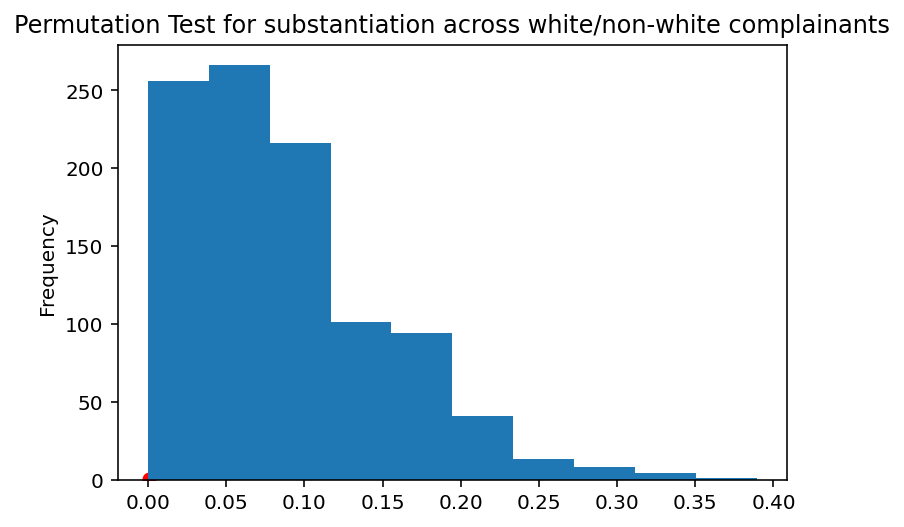

In [39]:
#Is this difference significant here, we will test using permutation!
obs = abs(results.groupby('is_white').apply(lambda x: metrics.recall_score(x.actual, x.prediction)).diff().iloc[-1])

metrs = []
for _ in range(1000):
    s = (
        results[['is_white', 'prediction', 'actual']]
        .assign(is_white=results.is_white.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_white')
        .apply(lambda x: metrics.recall_score(x.actual, x.prediction))
        .diff()
        .iloc[-1]
    )
    metrs.append(abs(s))
print(pd.Series(metrs >= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for substantiation across white/non-white complainants')
plt.scatter(obs, 0.1, c='r')